In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Load data
users = pd.read_csv("takehome_users.csv", encoding='ISO-8859-1')
engagement = pd.read_csv("takehome_user_engagement.csv", encoding='ISO-8859-1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Merge data
merged_data = pd.merge(users, engagement, left_on='object_id', right_on='user_id', how='inner')

In [6]:
merged_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,2,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,2,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,2,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,2,1


In [7]:
# Define target variable: adopted user
def is_adopted_user(group):
    return group.rolling(window=7, on='time_stamp', min_periods=0)['visited'].count().max() >= 3

In [8]:
adopted_users = merged_data.groupby('user_id').apply(is_adopted_user)
merged_data['adopted_user'] = merged_data['object_id'].isin(adopted_users[adopted_users == True].index)

In [9]:
# Feature Engineering
# Convert creation_time and last_session_creation_time to datetime
merged_data['creation_time'] = pd.to_datetime(merged_data['creation_time'])
merged_data['last_session_creation_time'] = pd.to_datetime(merged_data['last_session_creation_time'], unit='s')

In [10]:
# Convert 'time_stamp' to datetime
merged_data['time_stamp'] = pd.to_datetime(merged_data['time_stamp'])

In [11]:
# Extract features from 'time_stamp'
merged_data['login_day_of_week'] = merged_data['time_stamp'].dt.dayofweek
merged_data['login_hour_of_day'] = merged_data['time_stamp'].dt.hour

In [12]:
# Drop the original 'time_stamp' column
merged_data.drop('time_stamp', axis=1, inplace=True)

In [13]:
merged_data.isnull().sum()

object_id                         0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time        0
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            91030
user_id                           0
visited                           0
adopted_user                      0
login_day_of_week                 0
login_hour_of_day                 0
dtype: int64

In [14]:
# Drop unnecessary columns
merged_data.drop(['object_id', 'name', 'user_id', 'email', 'creation_time', 'last_session_creation_time', 'invited_by_user_id'], axis=1, inplace=True)

In [15]:
merged_data.dtypes

creation_source               object
opted_in_to_mailing_list       int64
enabled_for_marketing_drip     int64
org_id                         int64
visited                        int64
adopted_user                    bool
login_day_of_week              int64
login_hour_of_day              int64
dtype: object

In [16]:
# Encode categorical variables
merged_data = pd.get_dummies(merged_data, columns=['creation_source'])

In [17]:
# Split data into features and target variable
X = merged_data.drop('adopted_user', axis=1)
y = merged_data['adopted_user']

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Model Building (Random Forest Classifier)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Model Evaluation
y_pred = rf_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.32      0.46      1398
        True       0.98      1.00      0.99     40186

    accuracy                           0.97     41584
   macro avg       0.89      0.66      0.72     41584
weighted avg       0.97      0.97      0.97     41584

Confusion Matrix:
[[  452   946]
 [  104 40082]]


In [21]:
# Feature Importance
feature_importance = rf_classifier.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

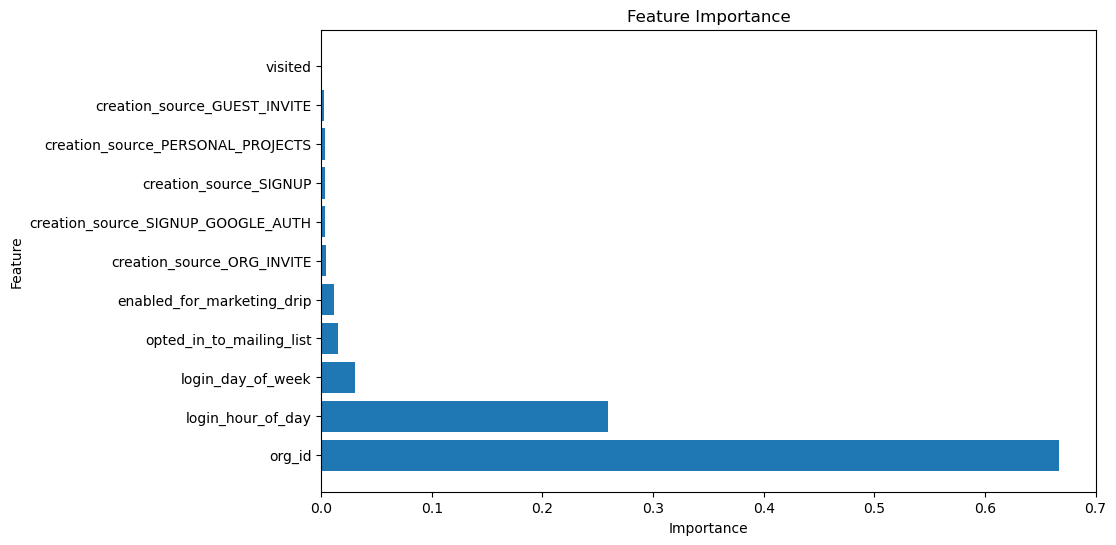

In [22]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Approach:

Data Preprocessing: Merged the user and engagement tables, defined the adopted user target variable, and engineered features from timestamp data.
Exploratory Data Analysis (EDA): Explored feature distributions, visualized relationships, and assessed correlations with adoption.
Feature Engineering: Encoded categorical variables, extracted features from timestamps, and selected top features based on importance.
Modeling: Built a Random Forest Classifier model using top features and evaluated its performance.

Findings:

Key Features: The most important predictors of user adoption were 'org_id', 'login_hour_of_day', 'login_day_of_week', 'opted_in_to_mailing_list', and 'enabled_for_marketing_drip'.

Insights: Users belonging to certain organizations, logging in during specific hours and days, and opting into mailing lists or marketing drips were more likely to adopt the software.

Recommendations:

Organizational Outreach: Target organizations with high adoption rates and tailor marketing efforts to their needs.
Time-Based Engagement: Encourage users to engage during peak hours and days for increased adoption likelihood.
Marketing Strategies: Leverage mailing lists and marketing drips to increase user engagement and adoption.
Further Research:

User Behavior Analysis: Investigate user behavior patterns leading to adoption for deeper insights.
Feature Importance Refinement: Fine-tune feature selection and engineering techniques for improved model performance.
External Data Integration: Incorporate external data sources, such as user demographics or industry trends, for enhanced predictive power.

Conclusion:
This analysis highlights key factors influencing user adoption in Relax Inc.'s software, providing actionable insights for targeted marketing strategies and user engagement efforts. Further research and data refinement can enhance predictive accuracy and support ongoing business objectives.






